## Comparing model score

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 글꼴깨짐 방지
import matplotlib
import matplotlib.font_manager as fm

import warnings

# 경고 메시지를 무시하고 숨기거나
warnings.filterwarnings(action='ignore')

fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/malgun.ttf' # For Windows
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

In [2]:
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

In [3]:
import joblib
import xgboost as xgb

catboost_model = joblib.load('./Catboost_GridSearchCV_model.pkl')
xgboost_model = joblib.load('./XGBoostingRegressor.pkl')
lightgbm_model = joblib.load('./lightgbm.pkl')

In [4]:
df = pd.read_csv('train.csv')

In [5]:
def preprocessing(df):
    # 오류 단지코드가 존재하는 행들을  사전에 제거
    df_error =  ['C1095', 'C2051', 'C1218', 'C1894', 'C2483', 'C1502', 'C1988']
    #df_error =  ['C2335', 'C1327']
    df = df[~df['단지코드'].isin(df_error)].reset_index(drop=True)
    df.rename(columns = {'도보 10분거리 내 지하철역 수(환승노선 수 반영)':'지하철','도보 10분거리 내 버스정류장 수':'버스'},inplace=True)
    df.drop(columns=['임대보증금','임대료','자격유형','임대건물구분'],axis = 1,inplace=True)
    지역_비율 = (df.groupby(['지역'])['총세대수'].count())/(df.groupby(['지역'])['총세대수'].count().sum())*100
    지역_비율=지역_비율.reset_index(name='지역_비율')
    공급유형_비율 = (df.groupby(['공급유형'])['총세대수'].count())/(df.groupby(['공급유형'])['총세대수'].count().sum())*100
    공급유형_비율=공급유형_비율.reset_index(name='공급유형_비율')
    df = pd.merge(df,지역_비율, on='지역')
    df = pd.merge(df,공급유형_비율, on='공급유형')
    df.drop(columns=['지역','공급유형','단지코드'],axis = 1,inplace=True)
    df=df.dropna(axis=0)
    df = df[['총세대수', '전용면적', '전용면적별세대수', '공가수', '지하철', '버스', '단지내주차면수', '공급유형_비율',
       '지역_비율', '등록차량수']]
    return df

In [6]:
df = preprocessing(df)

In [7]:
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

### train set, test set

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1]
y = df.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
base = X_test
target = y_test

## Evaluating Model

In [10]:
mae_dict = dict()

In [11]:
def evaluate_model(model):
    pred = model.predict(base)
    return mean_absolute_error(target, pred)

### base model: LinearRegression

In [12]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

mae_dict['LinearRegression'] = evaluate_model(lr)

### CatBoost

In [13]:
cat_param = {
    # tree의 깊이, default: 6
    'max_depth': [4, 6, 8, 10], 
    
    # 생성 가능한 최대 tree 갯수, default: 1000
    'n_estimators': [1000, 1500, 2000],
    
    # 오차 함수에서 조정하는 step의 크기, default: 자동 설정(0.03)
    'learning_rate': [0.01, 0.03, 0.1, None],
    
    # tree에 랜덤하게 부여되는 가중치, defaul: 1
    'rddandom_strength': [1, 1.2, 1.5, 2, 4]
}
# cat_best_param = learning_rate=0.01, max_depth=6, n_estimators=1000, random_strength=2)

In [14]:
mae_dict['CatBoost'] = evaluate_model(catboost_model)

### XGBoost

In [15]:
'''
n_estimators=100, learning_rate= 0.15, max_depth =3, gamma= 0, colsample_bytree = 0.9,
eval_metric= 'mae', scale_pos_weight=0.5, subsample=0.5,min_child_weight =20,
seed = 1337, reg_alpha= 0.01, reg_lambda=0.1'
'''

mae_dict['XGBoost'] = evaluate_model(xgboost_model)

### LightGBM

In [16]:
params = {'learning_rate': (0.2,0.3,0.4), # 부스팅 각 이터레이션 마다 곱해지는 가중치로 모형 성능과 학습시간에 영향을 준다. 
          'max_depth': [8, 4, 2, 1, -1],# 최대 깊이
          'boosting': ['gbdt'], # ecision tree와 학습 데이터의 일부만 사용하여 부스팅을 수행한다.
          'application':['mean_absolute_error'],
          'min_data_in_leaf':[20], # left가 가지고 있는 최소한의 레코드. 디폴트 값은 20을 해결 할때 사용
          'objective': ['regression'], # 회귀
          'metric': ['mae'],# Mean absolute error
          'maximum_leaves':[31],# 트리의  최대 리프 수. 트리의 최대 깊이, 모형 성능, 학습속도에 영향을 미친다.
          'max_cat_group' :[64], # 카테고리의 수가 클때, 분기 포인트를 찾음
          'is_training_metric': [True],
          'column_sampling':[0.3],# 각 이터레이션에 사용되는 칼럼의 비율
          'num_leaves': [144], # 'maximum_leaves' 와 함께 사용하는 파라미터 
          'feature_fraction': [1,0.7,0.6],# 각 이터레이션에 사용되는 칼럼의 비율. 
          'bagging_fraction': [0.7,0.3,0.1 ],# 일반적으로 훈련 속도를 높이거나, 과적합을 피할때 사용한다.
          'bagging_freq': [5] # 각 이터레이션에 사용되는 행의 비율}
         }
'''
 application= 'mean_absolute_error',
 bagging_fraction= 0.6,
 bagging_freq= 5,
 boosting= 'gbdt',
 feature_fraction= 0.9,
 is_training_metric= True,
 learning_rate= 0.1,
 max_cat_group= 64,
 max_depth= 4,
 metric= 'mae',
 min_data_in_leaf= 20,
 num_leaves= 144,
 objective= 'regression'
'''

"\n application= 'mean_absolute_error',\n bagging_fraction= 0.6,\n bagging_freq= 5,\n boosting= 'gbdt',\n feature_fraction= 0.9,\n is_training_metric= True,\n learning_rate= 0.1,\n max_cat_group= 64,\n max_depth= 4,\n metric= 'mae',\n min_data_in_leaf= 20,\n num_leaves= 144,\n objective= 'regression'\n"

In [17]:
from sklearn.preprocessing import StandardScaler

mae_dict['LightGBM'] = evaluate_model(lightgbm_model)

### CNN

In [18]:
mae_dict['CNN'] = 117.19342498779297

## Visualization

In [19]:
mae_dict

{'LinearRegression': 146.34365537491593,
 'CatBoost': 29.8928190870309,
 'XGBoost': 16.872810357109795,
 'LightGBM': 32.621006109570274,
 'CNN': 117.19342498779297}

In [20]:
mae_key = list(mae_dict.keys())
mae_value = list(mae_dict.values())

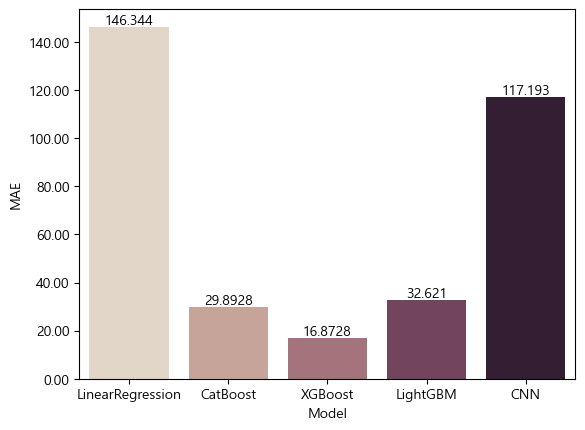

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots()

ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax = sns.barplot(x=mae_key, y=mae_value, palette="ch:.25")
plt.xlabel('Model')
plt.ylabel('MAE')

for i in ax.containers:
    ax.bar_label(i,)

plt.show()